## The Question
We recieve a stream of $N$ uniform $[0,1]$ random variables, one at a time. We can either keep or reject each random variable until we have selected a total of $M$. If we reject a variable, we cannot accept it later. What is the strategy to maximize the sum of the $M$ variables that we have selected? What is the expected value of this strategy?

Below is a problem representation. Clearly, if we just selected any $M$ variables we could expect to get a sum of $\frac{M}{2}$ - that is the default implementation.

Emperical mean: 20.00310636518123 Emperical stdev: 1.785373163482826


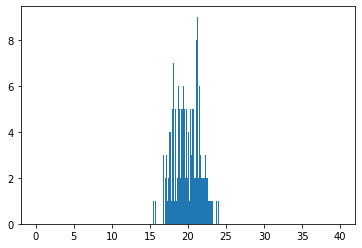

In [44]:
from random import random 
from statistics import mean, stdev
from matplotlib import pyplot

N = 1000
M = 40
num_trials = 1000
def problem_simulation(f = lambda cur_val,i,x: True if x < M else False):
    """
    N,M and trials are self explanatory
    f is your accept/reject function. The information that you get at each stage of the stream is the value of 
    the current random variable, the index of the current variable i, and how many random variables x you have 
    accepted already. i is 0 indexed!
    """
    def one_round():
        accepted = 0
        cur_sum = 0
        for i in range (N):
            cur_val = random()
            if f(cur_val, i, accepted):
                accepted+=1
                cur_sum+=cur_val
        return cur_sum
    results = []
    for _ in range (num_trials):
        results.append(one_round())
    pyplot.hist(results, bins = int (N/0.5), range = (0,M))
    return mean(results), stdev(results), results

def print_mean_stdev(t):
    print("Emperical mean:", t[0], "Emperical stdev:", t[1])
            
print_mean_stdev(problem_simulation())

## The Upper Limit

Assume that we were able to view all $N$ items and then simply collect the biggest $M$: i.e, we no longer had the limitation that after rejecting a variable, we lost it forever. Uniform Random variables have a nice property that if we have $n$ uniform random variables, then the expected value of the $k^{th}$ largest one will be $\frac{k}{N+1}$. Thus, the best $M$ will have expected sum equal to $\sum_{i=1}^M 1 - \frac{i}{N+1}$. Calculating this for our set $M$ and $N$, running a simulation to check my math: 

39.18081918081918
Emperical mean: 39.16829993048353 Emperical stdev: 0.14693268583207836


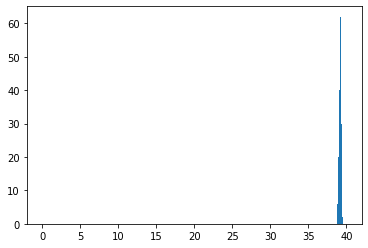

In [45]:
cur_sum = 0
for i in range (1, M+1):
    cur_sum += 1-i/(N+1)
print (cur_sum)
results = []
for _ in range (num_trials):
    l = [random() for _ in range (N)]
    l.sort()
    results.append(sum(l[N-M:]))
    
print_mean_stdev((mean(results), stdev(results)))
_=pyplot.hist(results, bins = int (N/0.5), range = (0,M))


## Naive Solution 

The general strategy is that we should only accept a random variable from the stream if it improves our expected value. Say that we have accepted $x$ random variables already, and we are seeing the index $i$ variable from the stream. If we dont accept this variable, then we need to chose $M-x$ variables from the next $N-i-1$ items. In the case where you could accept/reject after seeing all of the next $N-i-1$ variables, the expected value of the smallest value accepted would be $\frac{M-x}{N-i}$. This is not optimal, because you aren't going to be able to accept the true top $M-x$ variables every time, so our threshold for acceptance should actually probably be lower!

An implementation of this is:

Emperical mean: 25.44964812773828 Emperical stdev: 1.3973898180430742


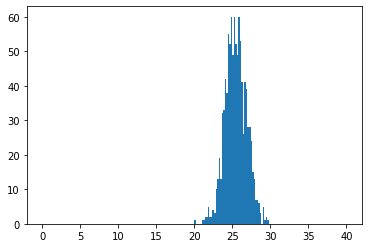

In [42]:
def naive_strategy(cur_value, i ,x):
    return x < M and cur_value > (M-x)/(N-i) 
print_mean_stdev(problem_simulation(f = naive_strategy))

# DP Solution

To account for the fact that we can't truly accept the top $M-x$ variables, I think we can use dp. Let $c(n,m)$ and be the cutoff for which we will accept a random variable with $n$ variables left in the stream in total and $m$ left to accept. If $dp(n,m)$ is the expectation using our strategy, then $$dp(n, m) = c(n, m)*dp(n-1, m) + (1-c(n, m))*(\frac{1+c(n,m)}{2} + dp(n-1, m-1))$$. 

The equation comes from: There is a $c(n,m)$ chance we reject the current variable and a $1-c(n,m)$ chance that we accept the current random variable. If we reject the current random variable, then the expectation is by definition $dp(n-1, m).$ If we accept it, the expecation of the accepted variable will be $\frac{1+c(n,m)}{2}$. The expectation of the rest of our strategy is $dp(n-1, m-1)$, so we add those quantities together to get the complete expecation in this case. 

We also have $$c(n, m) = dp (n-1, m) - dp (n-1, m-1)$$ It is only worth it for us to accept a random variable if the expecation for our strategy given that we accept it is greater than the expectation than if we didn't choose it. Remember that if we were to accept the current random variable, then the expecation of the rest of our strategy is $dp(n-1, m-1)$. So, $dp(n-1, m-1)+ c > dp(n-1, m)$, and rearranging we get our condition.

Base case wise, we know that $dp(n, 0) = 0$ and $dp(n,m) = dp (n,n)$ where $m>n$ 

Calculated Expectation 31.50067587898298
0.5962140925809862
Emperical mean: 31.522067352944273 Emperical stdev: 1.2736155608160062


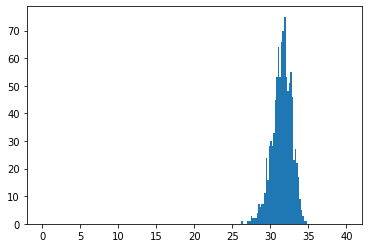

In [43]:
dp = [[0 for j in range (M+1)] for i in range (N+1)]
c = [[0 for j in range (M+1)] for i in range (N+1)]

for i in range (1, N+1):
    c[i][0] = 1
for n in range (1, N+1):
    for m in range (1, min(M+1, n+1)):
        c[n][m] = dp[n-1][m] - dp[n-1][m-1]
        dp[n][m] = c[n][m] * dp[n-1][m] + (1-c[n][m])*((1+c[n][m])/2 + dp[n-1][m-1])
    for m in range (n+1, M+1):
        dp[n][m] = dp[n][n]

print ("Calculated Expectation", dp[n][m])
print (c[n][m])
def dp_strat(cur_val, i, x):
    return x < M and cur_val > c[N-i][M-x]
print_mean_stdev(problem_simulation(f = dp_strat))